In [23]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [24]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs
import string


# For Training
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/dawidkubicki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load fastText embeddings

In [25]:
embeddings_index = {}
f = codecs.open('/home/dawidkubicki/Datasets/word_vectors/wiki-news-300d-1M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

999995it [00:46, 21645.93it/s]


In [26]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('train.csv', sep=',', header=0)
data = data.drop(columns=["id", "keyword", "location"])
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("test_dat.csv")
train_data.to_csv("train_dat.csv")

train_df = pd.read_csv('train_dat.csv', sep=',', header=0)
test_df = pd.read_csv('test_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

submit_test = pd.read_csv('test.csv')
submit_test = submit_test.drop(columns=["id", "keyword", "location"])

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  6090
Number of testing data:  1523


In [78]:
submit_test_final = pd.read_csv('test.csv')
submit_test_final_id = submit_test_final["id"]

In [27]:
train_df.head()

,Unnamed: 0,text,target
0,4996,Courageous and honest analysis of need to use ...,1
1,3263,@ZachZaidman @670TheScore wld b a shame if tha...,0
2,4907,Tell @BarackObama to rescind medals of 'honor'...,1
3,2855,Worried about how the CA drought might affect ...,1
4,4716,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0


/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


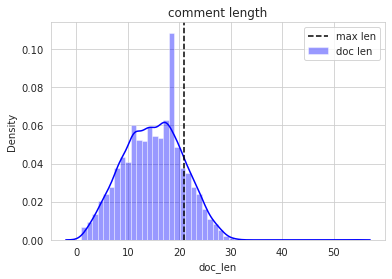

In [28]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

### Clean text

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

lemmatizer = WordNetLemmatizer()

train_df["text"] = train_df["text"].apply(lambda x: clean_text(x))
test_df["text"] = test_df["text"].apply(lambda x: clean_text(x))

submit_test["text"] = submit_test["text"].apply(lambda x: clean_text(x))
submit_test["text"] = submit_test["text"].apply(lambda x: lemmatizer.lemmatize(x))

train_df["text"] = train_df["text"].apply(lambda x: lemmatizer.lemmatize(x))
test_df["text"] = test_df["text"].apply(lambda x: lemmatizer.lemmatize(x))


### Tokenizing the data

In [30]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
raw_docs_submit_test = submit_test["text"].tolist()
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

# processed_docs_submit_test = []
# for doc in tqdm(raw_docs_submit_test):
#     tokens = word_tokenize(doc)
#     filtered = [word for word in tokens if word not in stop_words]
#     raw_docs_submit_test.append(" ".join(filtered))
# #end for


print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky



# tokenizer2 = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
# tokenizer2.fit_on_texts(processed_docs_submit_test)  #leaky

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
# word_seq_submit_test = tokenizer.texts_to_sequences(processed_docs_submit_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
# word_seq_submit_test = sequence.pad_sequences(word_seq_submit_test, maxlen=max_seq_len)

 22%|██▏       | 1353/6090 [00:00<00:00, 13524.82it/s]

pre-processing train data...


100%|██████████| 1523/1523 [00:00<00:00, 13736.82it/s]


tokenizing input data...
dictionary size:  16699


In [31]:
# processed_docs_submit_test = []
# for doc in tqdm(raw_docs_submit_test):
#     tokens = word_tokenize(doc)
#     filtered = [word for word in tokens if word not in stop_words]
#     raw_docs_submit_test.append(" ".join(filtered))
# #end for

In [62]:
tokenizer2 = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer2.fit_on_texts(raw_docs_submit_test)
word_seq_submit_test = tokenizer2.texts_to_sequences(raw_docs_submit_test)
word_seq_submit_test = sequence.pad_sequences(word_seq_submit_test, maxlen=max_seq_len)

### Some hyperparamers

In [33]:
#training params
batch_size = 256 
num_epochs = 15

#model parameters
num_filters = 128 
embed_dim = 300 
weight_decay = 1e-4

In [34]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 5453


In [35]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['easternoregon\x89û' 'madeif' 'legionstrackandfield' 'danagould'
 'saferåê' 'bu\x89û' 'listia' 'salmanmydarling' 'peeters' 'asukager']


### Training time

In [36]:
train_ds = tf.data.Dataset.from_tensor_slices((word_seq_train, y_train)).batch(256)

In [37]:
#model class

class TwitterModel(tf.keras.Model):
    def __init__(self):
        super(TwitterModel, self).__init__()
        self.emb = tf.keras.layers.Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False)
        self.bid1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
        self.bid2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
        self.d1 = tf.keras.layers.Dense(32, activation='relu')
        self.drop = tf.keras.layers.Dropout(0.2)
        self.d2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.emb(x)
        x = self.bid1(x)
        x = self.bid2(x)
        x = self.drop(x)
        return self.d2(x)
    
model = TwitterModel()    

In [38]:
#optimizer and loss function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop()

In [39]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name="train_accuracy")

In [40]:
def train_step(text, labels):
    with tf.GradientTape() as tape:
        prediction = model(text, training=True)
        loss = loss_object(labels, prediction)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, prediction)

In [41]:
EPOCHS = 15

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for text, labels in train_ds:
        train_step(text, labels)
        
    print(f'Epoch: {epoch+1}', f'Loss: {train_loss.result()}, ', f'Accuracy: {train_accuracy.result() * 100}')

Epoch: 1 Loss: 0.5564849376678467,  Accuracy: 72.97208404541016
Epoch: 2 Loss: 0.44639256596565247,  Accuracy: 80.37767028808594
Epoch: 3 Loss: 0.43168899416923523,  Accuracy: 81.44499206542969
Epoch: 4 Loss: 0.41907134652137756,  Accuracy: 82.03612518310547
Epoch: 5 Loss: 0.41223010420799255,  Accuracy: 82.2988510131836
Epoch: 6 Loss: 0.4045616388320923,  Accuracy: 82.56157684326172
Epoch: 7 Loss: 0.39694273471832275,  Accuracy: 82.88998413085938
Epoch: 8 Loss: 0.3911914825439453,  Accuracy: 83.44827270507812
Epoch: 9 Loss: 0.3827528655529022,  Accuracy: 83.84236907958984
Epoch: 10 Loss: 0.3749133348464966,  Accuracy: 84.40065002441406
Epoch: 11 Loss: 0.3699709475040436,  Accuracy: 84.38423919677734
Epoch: 12 Loss: 0.36563238501548767,  Accuracy: 85.0574722290039
Epoch: 13 Loss: 0.35665056109428406,  Accuracy: 84.89326477050781
Epoch: 14 Loss: 0.34282562136650085,  Accuracy: 85.92774963378906
Epoch: 15 Loss: 0.3408181369304657,  Accuracy: 85.91133117675781


In [63]:
test_pred = model.predict(word_seq_submit_test)
test_pred_int = test_pred[:,0] >= 0.5
test_pred_int = test_pred_int.astype(np.int)

In [65]:
print(test_pred_int.shape)

(3263,)


In [ ]:
result = np.column_stack((index, npsol))

In [72]:

submit_test['target'] = test_pred_int
# submission = submit_test
# submission.drop(columns=["text"])
# submission.to_csv('submission.csv', index=False)
# submission

,text,target
0,just happened a terrible car crash,0
1,heard about earthquake is different cities sta...,1
2,there is a forest fire at spot pond geese are ...,0
3,apocalypse lighting spokane wildfires,0
4,typhoon soudelor kills in china and taiwan,1
...,...,...
3258,earthquake safety los angeles ûò safety faste...,0
3259,storm in ri worse than last hurricane my hard...,1
3260,green line derailment in chicago,1
3261,meg issues hazardous weather outlook hwo,0


In [74]:
submit_test = submit_test.drop(columns=["text"])

In [85]:
submit_test = submit_test.drop(columns=["id"])

In [86]:
submit_test.insert(0, 'id', submit_test_final_id)

In [87]:
submit_test

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0


In [88]:
submit_test.to_csv("submission.csv", index=False)